In [10]:
import pandas as pd
import numpy as np
from fractions import Fraction

# Load the dataset
file_path = "fraudTrain.csv"
df = pd.read_csv(file_path)

# Selecting the transaction amount column for clustering
transaction_amounts = df["amt"].astype(int).unique()

# Function to generate prime numbers up to a given limit
def generate_primes(limit):
    sieve = [True] * (limit + 1)
    sieve[0] = sieve[1] = False
    for start in range(2, int(limit ** 0.5) + 1):
        if sieve[start]:
            for multiple in range(start * start, limit + 1, start):
                sieve[multiple] = False
    return [num for num, is_prime in enumerate(sieve) if is_prime]

# Function to select relevant prime numbers based on the dataset
def select_relevant_primes(data, prime_limit=50):
    primes = generate_primes(prime_limit)
    return [p for p in primes if any(x % p == 0 for x in data)]

# Final transformation function to prevent zero denominator errors
def transform_by_prime(x, prime):
    if x % prime != 0:
        return Fraction(1, 1)
    exponent = max(1, x // prime)
    return Fraction(1, prime ** exponent)

# Selecting relevant primes dynamically
selected_primes = select_relevant_primes(transaction_amounts, prime_limit=50)

# Applying transformation for dynamically selected primes
transformed_data = {f"Transformed by {p}": [transform_by_prime(x, p) for x in transaction_amounts] for p in selected_primes}

# Convert transformed data to DataFrame
df_transformed = pd.DataFrame(transformed_data, index=transaction_amounts)

# Assigning clusters based on the smallest transformation value
clusters = []
for x in transaction_amounts:
    valid_transformations = {p: transform_by_prime(x, p) for p in selected_primes}
    min_prime = min(valid_transformations, key=lambda p: valid_transformations[p])
    clusters.append(f"Cluster (Divisible by {min_prime} smallest)")

df_transformed["Assigned Cluster"] = clusters

# Detect potential fraudulent transactions (isolated clusters)
unique_clusters = df_transformed["Assigned Cluster"].value_counts()
fraudulent_transactions = df_transformed[df_transformed["Assigned Cluster"].isin(unique_clusters[unique_clusters == 1].index)]

# Display results
import ace_tools as tools
tools.display_dataframe_to_user(name="Fraud Detection Clustering", dataframe=df_transformed)
tools.display_dataframe_to_user(name="Potential Fraudulent Transactions", dataframe=fraudulent_transactions)


ZeroDivisionError: Fraction(1, 0)

In [ ]:
!pip install ace_tools

Defaulting to user installation because normal site-packages is not writeable


In [3]:
from fractions import Fraction

result = Fraction(1, 2)
print(result)  # Output: 1/2

1/2


In [4]:
# Print basic statistics
print(df['amt'].describe())

# Show sample of data
print("\nSample of data:")
print(df['amt'].head())

# Check for missing values
print("\nMissing values count:", df['amt'].isnull().sum())

# Check for outliers
q75, q95 = np.percentile(df['amt'], [75, 95])
print("\nOutliers (>2*interquartile range):")
print(df[(df['amt'] > q75 + 1.5*(q95-q75)) & (df['amt'] != 0)])

# Check for extreme values
print("\nExtreme values (>3*standard deviation):")
print(df[(np.abs(df['amt'] - df['amt'].mean()) > (3 * df['amt'].std()))])

# Check for negative values
print("\nNumber of negative values:", df['amt'][df['amt'] < 0].count())

count    1.296675e+06
mean     7.035104e+01
std      1.603160e+02
min      1.000000e+00
25%      9.650000e+00
50%      4.752000e+01
75%      8.314000e+01
max      2.894890e+04
Name: amt, dtype: float64

Sample of data:
0      4.97
1    107.23
2    220.11
3     45.00
4     41.96
Name: amt, dtype: float64

Missing values count: 0

Outliers (>2*interquartile range):
         Unnamed: 0 trans_date_trans_time               cc_num  \
16               16   2019-01-01 00:10:49     6011860238257910   
17               17   2019-01-01 00:10:58     3565423334076143   
67               67   2019-01-01 00:48:09     4707867759656333   
73               73   2019-01-01 00:56:12     3558881852140592   
138             138   2019-01-01 01:41:22     4060579726528237   
...             ...                   ...                  ...   
1296482     1296482   2020-06-21 10:33:36     4839615922685395   
1296547     1296547   2020-06-21 11:07:51        4755696071492   
1296557     1296557   2020-06-21 11:14:0

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fractions import Fraction

# Load the dataset
file_path = "fraudTrain.csv"  # Update this path as needed
df = pd.read_csv(file_path)

# Selecting the transaction amount column for clustering
transaction_amounts = df["amt"].astype(int).unique()

# Function to generate prime numbers up to a given limit
def generate_primes(limit):
    sieve = [True] * (limit + 1)
    sieve[0] = sieve[1] = False
    for start in range(2, int(limit ** 0.5) + 1):
        if sieve[start]:
            for multiple in range(start * start, limit + 1, start):
                sieve[multiple] = False
    return [num for num, is_prime in enumerate(sieve) if is_prime]

# Function to select relevant prime numbers based on the dataset
def select_relevant_primes(data, prime_limit=50):
    primes = generate_primes(prime_limit)
    return [p for p in primes if any(x % p == 0 for x in data)]

# Safe transformation function with exponent cap at 100 to prevent overflow
def transform_by_prime_safe(x, prime, max_exponent=100):
    if x % prime != 0:
        return Fraction(1, 1)
    
    exponent = min(max(1, x // prime), max_exponent)  # Cap exponent at 100
    denominator = prime ** exponent

    if denominator > 10**15:  # Prevent excessively large fractions
        return Fraction(1, 10**15)

    return Fraction(1, denominator)

# Selecting relevant primes dynamically
selected_primes = select_relevant_primes(transaction_amounts, prime_limit=50)

# Applying transformation for dynamically selected primes with capped exponent at 100
transformed_data = {
    f"Transformed by {p}": [transform_by_prime_safe(x, p) for x in transaction_amounts] for p in selected_primes
}

# Convert transformed data to DataFrame
df_transformed = pd.DataFrame(transformed_data, index=transaction_amounts)

# Assigning clusters based on the smallest transformation value
clusters = []
for x in transaction_amounts:
    valid_transformations = {p: transform_by_prime_safe(x, p) for p in selected_primes}
    min_prime = min(valid_transformations, key=lambda p: valid_transformations[p])
    clusters.append(f"Cluster (Divisible by {min_prime} smallest)")

df_transformed["Assigned Cluster"] = clusters

# Detect potential fraudulent transactions (isolated clusters)
unique_clusters = df_transformed["Assigned Cluster"].value_counts()
fraudulent_transactions = df_transformed[df_transformed["Assigned Cluster"].isin(unique_clusters[unique_clusters == 1].index)]

# Visualization: Cluster Distribution
plt.figure(figsize=(12, 6))
df_transformed["Assigned Cluster"].value_counts().plot(kind="bar", color="blue")
plt.xlabel("Cluster")
plt.ylabel("Number of Transactions")
plt.title("Transaction Cluster Distribution")
plt.xticks(rotation=90)
plt.show()

# Visualization: Highlighting Potential Fraudulent Transactions
plt.figure(figsize=(12, 6))
plt.scatter(df_transformed.index, [1] * len(df_transformed), c="blue", label="Normal Transactions", alpha=0.6)
plt.scatter(fraudulent_transactions.index, [1] * len(fraudulent_transactions), c="red", label="Potential Fraud", alpha=0.8)
plt.xlabel("Transaction Amount")
plt.title("Fraud Detection in Transactions")
plt.legend()
plt.show()


/home/coe_iot_ai/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


ZeroDivisionError: Fraction(1, 0)

Transaction: 4, Assigned Cluster: Cluster (Divisible by 2 smallest)
Transaction: 107, Assigned Cluster: Cluster (Divisible by 2 smallest)
Transaction: 220, Assigned Cluster: Cluster (Divisible by 11 smallest)
Transaction: 45, Assigned Cluster: Cluster (Divisible by 3 smallest)
Transaction: 41, Assigned Cluster: Cluster (Divisible by 41 smallest)
Transaction: 94, Assigned Cluster: Cluster (Divisible by 47 smallest)
Transaction: 44, Assigned Cluster: Cluster (Divisible by 11 smallest)
Transaction: 71, Assigned Cluster: Cluster (Divisible by 2 smallest)
Transaction: 198, Assigned Cluster: Cluster (Divisible by 11 smallest)
Transaction: 24, Assigned Cluster: Cluster (Divisible by 2 smallest)
Transaction: 7, Assigned Cluster: Cluster (Divisible by 7 smallest)
Transaction: 96, Assigned Cluster: Cluster (Divisible by 2 smallest)
Transaction: 3, Assigned Cluster: Cluster (Divisible by 3 smallest)
Transaction: 327, Assigned Cluster: Cluster (Divisible by 3 smallest)
Transaction: 341, Assigned C

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2458,) and arg 1 with shape (15,).

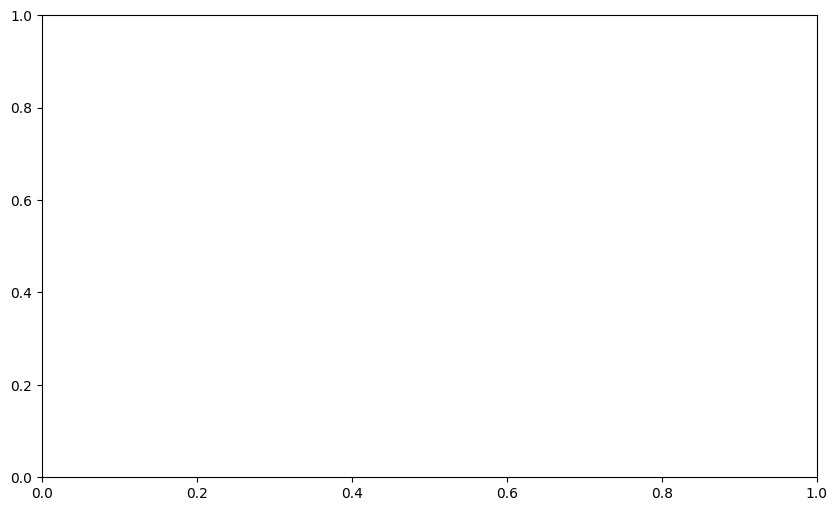

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

def calculate_exponent_p(n, p):
    """
    Calculate the exponent_p(n) based on the largest power of p that divides n.
    """
    alpha = 1
    while n % (p ** alpha) == 0:  # Check if p^alpha divides n
        alpha += 1
    return alpha - 1   # Return the largest valid alpha

def f(x, p):
    """
    Calculate f(x) = 1 / p^(exponent_p(n)).
    """
    exponent = calculate_exponent_p(x, p)
    return 1 / (p ** exponent)

def generate_primes(limit):
    """
    Generate a list of prime numbers up to a given limit.
    """
    sieve = [True] * (limit + 1)
    sieve[0] = sieve[1] = False
    for start in range(2, int(limit ** 0.5) + 1):
        if sieve[start]:
            for multiple in range(start * start, limit + 1, start):
                sieve[multiple] = False
    return [num for num, is_prime in enumerate(sieve) if is_prime]

def select_relevant_primes(data, prime_limit=50):
    """
    Select relevant primes based on whether they divide elements in the data.
    """
    primes = generate_primes(prime_limit)
    return [p for p in primes if any(x % p == 0 for x in data)]

def transform_by_prime_safe(x, prime, max_exponent=100):
    """
    Transform a number based on the largest power of a prime that divides it, capped at a maximum exponent.
    """
    if x % prime != 0:
        return 1  # Return 1 if not divisible
    exponent = min(max(1, calculate_exponent_p(x, prime)), max_exponent)  # Cap exponent
    return 1 / (prime ** exponent)

def cluster_transactions(transaction_amounts, prime_limit=50, max_exponent=100):
    """
    Cluster transactions based on divisibility by dynamically selected primes.
    """
    selected_primes = select_relevant_primes(transaction_amounts, prime_limit)
    transformed_data = {
        f"Transformed by {p}": [transform_by_prime_safe(x, p, max_exponent) for x in transaction_amounts]
        for p in selected_primes
    }
    
    # Assign clusters based on the smallest transformation value
    clusters = []
    for x in transaction_amounts:
        valid_transformations = {p: transform_by_prime_safe(x, p, max_exponent) for p in selected_primes}
        min_prime = min(valid_transformations, key=lambda p: valid_transformations[p])
        clusters.append(f"Cluster (Divisible by {min_prime} smallest)")

    return transformed_data, clusters

# File input for credit card fraud detection dataset
input_file = "fraudTrain.csv"  # Replace with your file path
# Assuming the transaction amounts are in a column named 'Amount'
df = pd.read_csv(input_file)
transaction_amounts = df['amt'].astype(int).unique()

# Process transactions
transformed_data, clusters = cluster_transactions(transaction_amounts)

# Print results
for amount, cluster in zip(transaction_amounts, clusters):
    print(f"Transaction: {amount}, Assigned Cluster: {cluster}")

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(range(len(transaction_amounts)), [clusters.count(f"Cluster (Divisible by {key} smallest)") for key in set(clusters)], color="blue")
plt.xlabel("Transaction Cluster Index")
plt.ylabel("Number of Transactions")
plt.title("Transaction Clusters Visualization")
plt.show()


Transaction: 4, Assigned Cluster: Cluster (Divisible by 2 smallest)
Transaction: 107, Assigned Cluster: Cluster (Divisible by 2 smallest)
Transaction: 220, Assigned Cluster: Cluster (Divisible by 11 smallest)
Transaction: 45, Assigned Cluster: Cluster (Divisible by 3 smallest)
Transaction: 41, Assigned Cluster: Cluster (Divisible by 41 smallest)
Transaction: 94, Assigned Cluster: Cluster (Divisible by 47 smallest)
Transaction: 44, Assigned Cluster: Cluster (Divisible by 11 smallest)
Transaction: 71, Assigned Cluster: Cluster (Divisible by 2 smallest)
Transaction: 198, Assigned Cluster: Cluster (Divisible by 11 smallest)
Transaction: 24, Assigned Cluster: Cluster (Divisible by 2 smallest)
Transaction: 7, Assigned Cluster: Cluster (Divisible by 7 smallest)
Transaction: 96, Assigned Cluster: Cluster (Divisible by 2 smallest)
Transaction: 3, Assigned Cluster: Cluster (Divisible by 3 smallest)
Transaction: 327, Assigned Cluster: Cluster (Divisible by 3 smallest)
Transaction: 341, Assigned C

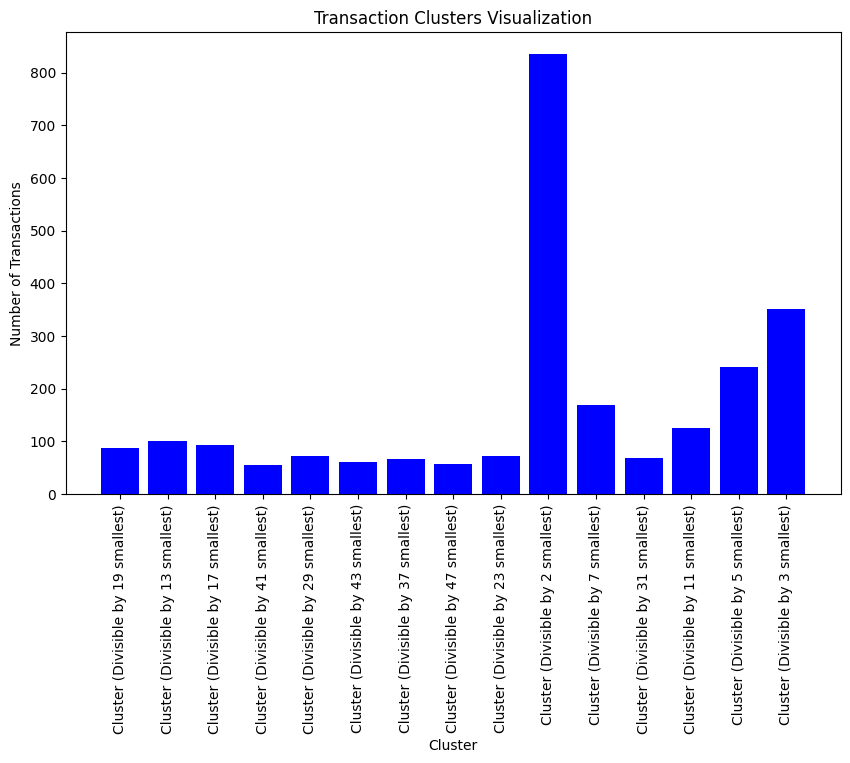


List of selected primes:
[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47]


In [19]:
import matplotlib.pyplot as plt
import pandas as pd

def calculate_exponent_p(n, p):
    """
    Calculate the exponent_p(n) based on the largest power of p that divides n.
    """
    alpha = 1
    while n % (p ** alpha) == 0:  # Check if p^alpha divides n
        alpha += 1
    return alpha - 1   # Return the largest valid alpha

def f(x, p):
    """
    Calculate f(x) = 1 / p^(exponent_p(n)).
    """
    exponent = calculate_exponent_p(x, p)
    return 1 / (p ** exponent)

def generate_primes(limit):
    """
    Generate a list of prime numbers up to a given limit.
    """
    sieve = [True] * (limit + 1)
    sieve[0] = sieve[1] = False
    for start in range(2, int(limit ** 0.5) + 1):
        if sieve[start]:
            for multiple in range(start * start, limit + 1, start):
                sieve[multiple] = False
    return [num for num, is_prime in enumerate(sieve) if is_prime]

def select_relevant_primes(data, prime_limit=50):
    """
    Select relevant primes based on whether they divide elements in the data.
    """
    primes = generate_primes(prime_limit)
    return [p for p in primes if any(x % p == 0 for x in data)]

def transform_by_prime_safe(x, prime, max_exponent=100):
    """
    Transform a number based on the largest power of a prime that divides it, capped at a maximum exponent.
    """
    if x % prime != 0:
        return 1  # Return 1 if not divisible
    exponent = min(max(1, calculate_exponent_p(x, prime)), max_exponent)  # Cap exponent
    return 1 / (prime ** exponent)

def cluster_transactions(transaction_amounts, prime_limit=50, max_exponent=100):
    """
    Cluster transactions based on divisibility by dynamically selected primes.
    """
    selected_primes = select_relevant_primes(transaction_amounts, prime_limit)
    transformed_data = {
        f"Transformed by {p}": [transform_by_prime_safe(x, p, max_exponent) for x in transaction_amounts]
        for p in selected_primes
    }
    
    # Assign clusters based on the smallest transformation value
    clusters = []
    for x in transaction_amounts:
        valid_transformations = {p: transform_by_prime_safe(x, p, max_exponent) for p in selected_primes}
        min_prime = min(valid_transformations, key=lambda p: valid_transformations[p])
        clusters.append(f"Cluster (Divisible by {min_prime} smallest)")

    return transformed_data, clusters

# File input for credit card fraud detection dataset
input_file = "fraudTrain.csv"  # Replace with your file path
# Assuming the transaction amounts are in a column named 'Amount'
df = pd.read_csv(input_file)
transaction_amounts = df['amt'].astype(int).unique()

# Process transactions
transformed_data, clusters = cluster_transactions(transaction_amounts)

# Print results
for amount, cluster in zip(transaction_amounts, clusters):
    print(f"Transaction: {amount}, Assigned Cluster: {cluster}")

# Visualization
plt.figure(figsize=(10, 6))
cluster_counts = {cluster: clusters.count(cluster) for cluster in set(clusters)}
plt.bar(cluster_counts.keys(), cluster_counts.values(), color="blue")
plt.xticks(rotation=90)
plt.xlabel("Cluster")
plt.ylabel("Number of Transactions")
plt.title("Transaction Clusters Visualization")
plt.show()
print("\nList of selected primes:")
print(selected_primes)

In [20]:
print(f"\nTotal number of primes selected: {len(selected_primes)}")


Total number of primes selected: 15


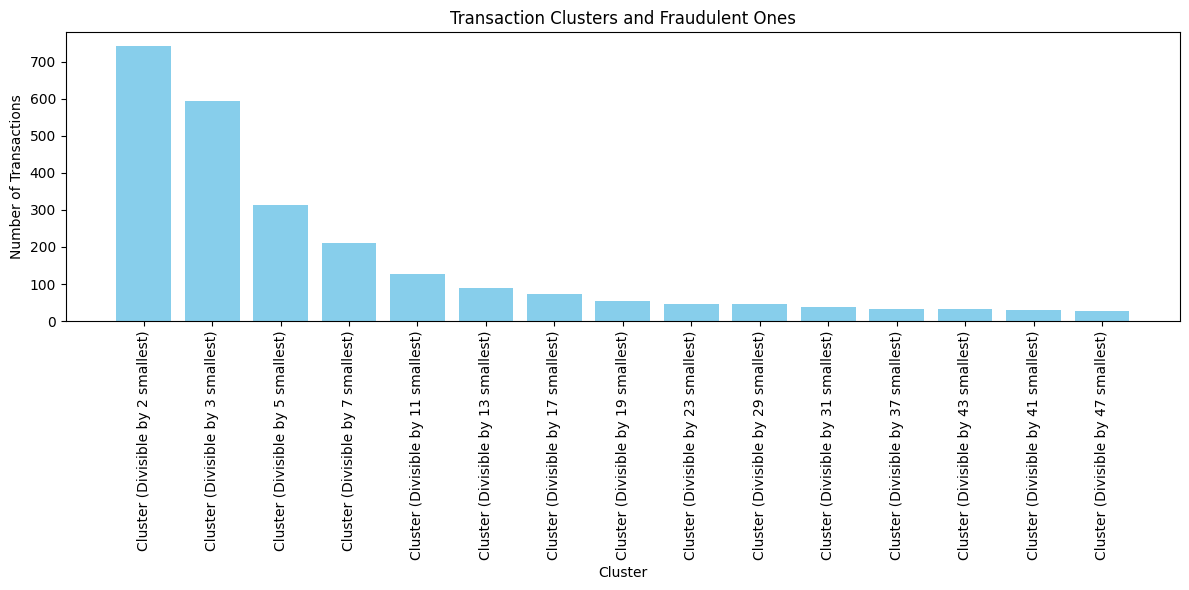


Summary of clusters:
Cluster (Divisible by 2 smallest): 742 transactions
Cluster (Divisible by 3 smallest): 595 transactions
Cluster (Divisible by 5 smallest): 314 transactions
Cluster (Divisible by 7 smallest): 211 transactions
Cluster (Divisible by 11 smallest): 126 transactions
Cluster (Divisible by 13 smallest): 90 transactions
Cluster (Divisible by 17 smallest): 74 transactions
Cluster (Divisible by 19 smallest): 53 transactions
Cluster (Divisible by 23 smallest): 47 transactions
Cluster (Divisible by 29 smallest): 47 transactions
Cluster (Divisible by 31 smallest): 37 transactions
Cluster (Divisible by 37 smallest): 33 transactions
Cluster (Divisible by 43 smallest): 32 transactions
Cluster (Divisible by 41 smallest): 30 transactions
Cluster (Divisible by 47 smallest): 27 transactions


In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from fractions import Fraction

# ... (previous code remains the same until the clustering step)

# Get the counts of transactions in each cluster
cluster_counts = df_transformed["Assigned Cluster"].value_counts()

# Identify fraudulent clusters (those with only one transaction)
fraudulent_clusters = df_transformed[df_transformed["Assigned Cluster"].isin(cluster_counts[cluster_counts == 1].index)]

# Create a bar plot
plt.figure(figsize=(12, 6))

# Plot the cluster counts
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')

# Highlight fraudulent clusters
for i, cluster in enumerate(fraudulent_clusters["Assigned Cluster"]):
    plt.text(i, cluster_counts[cluster] + 1, f"F({cluster_counts[cluster]})", ha='center', va='bottom', color='red')

# Set labels and title
plt.xlabel("Cluster")
plt.ylabel("Number of Transactions")
plt.title("Transaction Clusters and Fraudulent Ones")

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

# Print summary
print("\nSummary of clusters:")
for cluster, count in cluster_counts.items():
    print(f"{cluster}: {count} transactions")
    if count == 1:
        print(f"  Fraudulent cluster: {cluster}")

Fraudulent Transactions: [41, 94, 341, 57, 46, 82, 207, 221, 102, 58, 62, 92, 186, 43, 51, 47, 215, 129, 38, 34, 23, 187, 68, 69, 184, 123, 204, 145, 31, 76, 119, 74, 29, 19, 185, 464, 111, 93, 205, 87, 494, 203, 124, 209, 95, 17, 141, 217, 85, 138, 37, 136, 116, 407, 114, 86, 115, 148, 133, 152, 658, 155, 161, 222, 333, 153, 266, 304, 348, 170, 1025, 456, 171, 238, 248, 188, 172, 276, 666, 437, 232, 319, 285, 430, 342, 602, 684, 344, 533, 228, 174, 1254, 190, 620, 272, 966, 1015, 492, 374, 1426, 470, 722, 627, 310, 299, 799, 279, 476, 258, 287, 705, 323, 465, 164, 230, 246, 261, 451, 247, 483, 253, 855, 434, 481, 403, 391, 282, 408, 828, 255, 570, 527, 912, 377, 595, 598, 306, 289, 870, 296, 301, 370, 345, 609, 329, 361, 435, 340, 564, 1118, 555, 1003, 1131, 493, 897, 651, 775, 561, 235, 1909, 1104, 1044, 1148, 387, 1161, 846, 259, 510, 2116, 368, 328, 638, 1058, 644, 516, 1081, 2665, 696, 741, 1116, 952, 725, 744, 529, 522, 1288, 816, 714, 665, 442, 496, 558, 369, 690, 969, 1034, 559

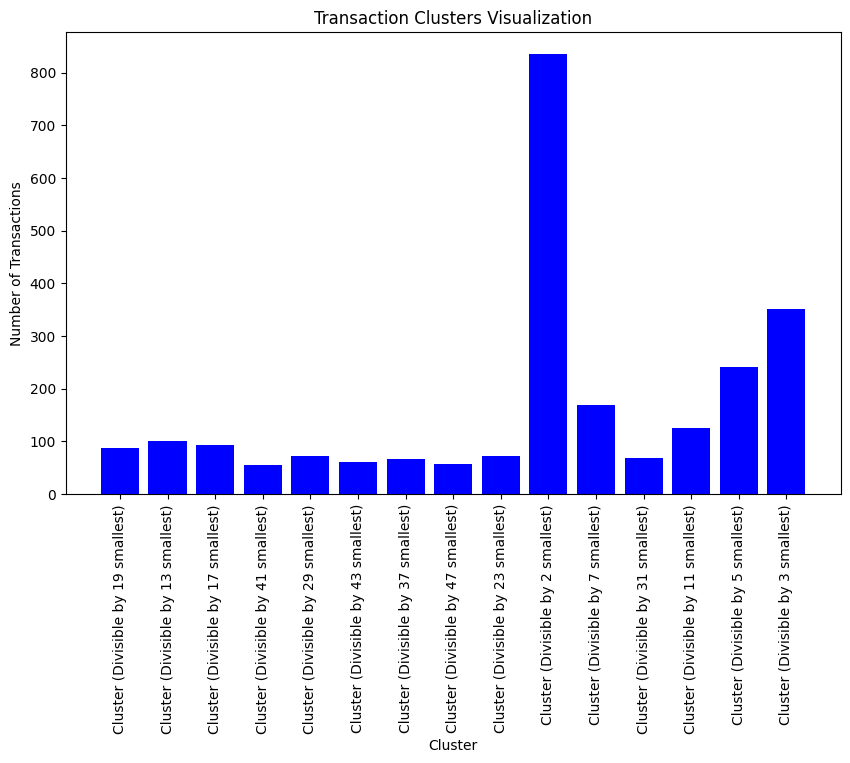

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

def calculate_exponent_p(n, p):
    """
    Calculate the exponent_p(n) based on the largest power of p that divides n.
    """
    alpha = 1
    while n % (p ** alpha) == 0:  # Check if p^alpha divides n
        alpha += 1
    return alpha - 1   # Return the largest valid alpha

def f(x, p):
    """
    Calculate f(x) = 1 / p^(exponent_p(n)).
    """
    exponent = calculate_exponent_p(x, p)
    return 1 / (p ** exponent)

def generate_primes(limit):
    """
    Generate a list of prime numbers up to a given limit.
    """
    sieve = [True] * (limit + 1)
    sieve[0] = sieve[1] = False
    for start in range(2, int(limit ** 0.5) + 1):
        if sieve[start]:
            for multiple in range(start * start, limit + 1, start):
                sieve[multiple] = False
    return [num for num, is_prime in enumerate(sieve) if is_prime]

def select_relevant_primes(data, prime_limit=50):
    """
    Select relevant primes based on whether they divide elements in the data.
    """
    primes = generate_primes(prime_limit)
    return [p for p in primes if any(x % p == 0 for x in data)]

def transform_by_prime_safe(x, prime, max_exponent=100):
    """
    Transform a number based on the largest power of a prime that divides it, capped at a maximum exponent.
    """
    if x % prime != 0:
        return 1  # Return 1 if not divisible
    exponent = min(max(1, calculate_exponent_p(x, prime)), max_exponent)  # Cap exponent
    return 1 / (prime ** exponent)

def cluster_transactions(transaction_amounts, prime_limit=50, max_exponent=100):
    """
    Cluster transactions based on divisibility by dynamically selected primes.
    """
    selected_primes = select_relevant_primes(transaction_amounts, prime_limit)
    transformed_data = {
        f"Transformed by {p}": [transform_by_prime_safe(x, p, max_exponent) for x in transaction_amounts]
        for p in selected_primes
    }
    
    # Assign clusters based on the smallest transformation value
    clusters = []
    for x in transaction_amounts:
        valid_transformations = {p: transform_by_prime_safe(x, p, max_exponent) for p in selected_primes}
        min_prime = min(valid_transformations, key=lambda p: valid_transformations[p])
        clusters.append(f"Cluster (Divisible by {min_prime} smallest)")

    return transformed_data, clusters

def detect_fraudulent_transactions(transaction_amounts, clusters, threshold=100):
    """
    Detect fraudulent transactions based on clusters with a small number of transactions.
    Transactions in clusters with occurrences below the threshold are considered fraudulent.
    """
    cluster_counts = {cluster: clusters.count(cluster) for cluster in set(clusters)}
    fraudulent_clusters = [cluster for cluster, count in cluster_counts.items() if count <= threshold]
    fraudulent_transactions = [amount for amount, cluster in zip(transaction_amounts, clusters) if cluster in fraudulent_clusters]
    return fraudulent_transactions

# File input for credit card fraud detection dataset
input_file = "fraudTrain.csv"  # Replace with your file path
# Assuming the transaction amounts are in a column named 'Amount'
df = pd.read_csv(input_file)
transaction_amounts = df['amt'].astype(int).unique()

# Process transactions
transformed_data, clusters = cluster_transactions(transaction_amounts)

# Detect fraudulent transactions
fraudulent_transactions = detect_fraudulent_transactions(transaction_amounts, clusters)
print("Fraudulent Transactions:", fraudulent_transactions)

# Print results
for amount, cluster in zip(transaction_amounts, clusters):
    print(f"Transaction: {amount}, Assigned Cluster: {cluster}")

# Visualization
plt.figure(figsize=(10, 6))
cluster_counts = {cluster: clusters.count(cluster) for cluster in set(clusters)}
plt.bar(cluster_counts.keys(), cluster_counts.values(), color="blue")
plt.xticks(rotation=90)
plt.xlabel("Cluster")
plt.ylabel("Number of Transactions")
plt.title("Transaction Clusters Visualization")
plt.show()


In [43]:
# Detect fraudulent transactions
fraudulent_transactions = detect_fraudulent_transactions(transaction_amounts, clusters)
print("Fraudulent Transactions:", fraudulent_transactions)

Fraudulent Transactions: [41, 94, 341, 57, 46, 82, 207, 221, 102, 58, 62, 92, 186, 43, 51, 47, 215, 129, 38, 34, 23, 187, 68, 69, 184, 123, 204, 145, 31, 76, 119, 74, 29, 19, 185, 464, 111, 93, 205, 87, 494, 203, 124, 209, 95, 17, 141, 217, 85, 138, 37, 136, 116, 407, 114, 86, 115, 148, 133, 152, 658, 155, 161, 222, 333, 153, 266, 304, 348, 170, 1025, 456, 171, 238, 248, 188, 172, 276, 666, 437, 232, 319, 285, 430, 342, 602, 684, 344, 533, 228, 174, 1254, 190, 620, 272, 966, 1015, 492, 374, 1426, 470, 722, 627, 310, 299, 799, 279, 476, 258, 287, 705, 323, 465, 164, 230, 246, 261, 451, 247, 483, 253, 855, 434, 481, 403, 391, 282, 408, 828, 255, 570, 527, 912, 377, 595, 598, 306, 289, 870, 296, 301, 370, 345, 609, 329, 361, 435, 340, 564, 1118, 555, 1003, 1131, 493, 897, 651, 775, 561, 235, 1909, 1104, 1044, 1148, 387, 1161, 846, 259, 510, 2116, 368, 328, 638, 1058, 644, 516, 1081, 2665, 696, 741, 1116, 952, 725, 744, 529, 522, 1288, 816, 714, 665, 442, 496, 558, 369, 690, 969, 1034, 559

In [44]:
import pandas as pd
import numpy as np
from fractions import Fraction

# ... (previous code remains the same until the clustering step)

# Get the counts of transactions in each cluster
cluster_counts = df_transformed["Assigned Cluster"].value_counts()

# Identify fraudulent clusters (those with only one transaction)
fraudulent_clusters = df_transformed[df_transformed["Assigned Cluster"].isin(cluster_counts[cluster_counts == 1].index)]

# Print fraudulent transactions with their clusters and details
print("\nFraudulent Transactions:")
for _, row in fraudulent_clusters.iterrows():
    print(f"Transaction ID: {row.name}, "
          f"Amount: {row['amt']}, "
          f"Cluster: {row['Assigned Cluster']}, "
          f"Date: {row['date']}, "
          f"User ID: {row['user_id']}")

# Print summary of fraudulent clusters
print("\nSummary of Fraudulent Clusters:")
for cluster in fraudulent_clusters["Assigned Cluster"].unique():
    count = len(fraudulent_clusters[fraudulent_clusters["Assigned Cluster"] == cluster])
    print(f"Cluster {cluster}: {count} fraudulent transactions")


Fraudulent Transactions:

Summary of Fraudulent Clusters:


Fraudulent Transactions:


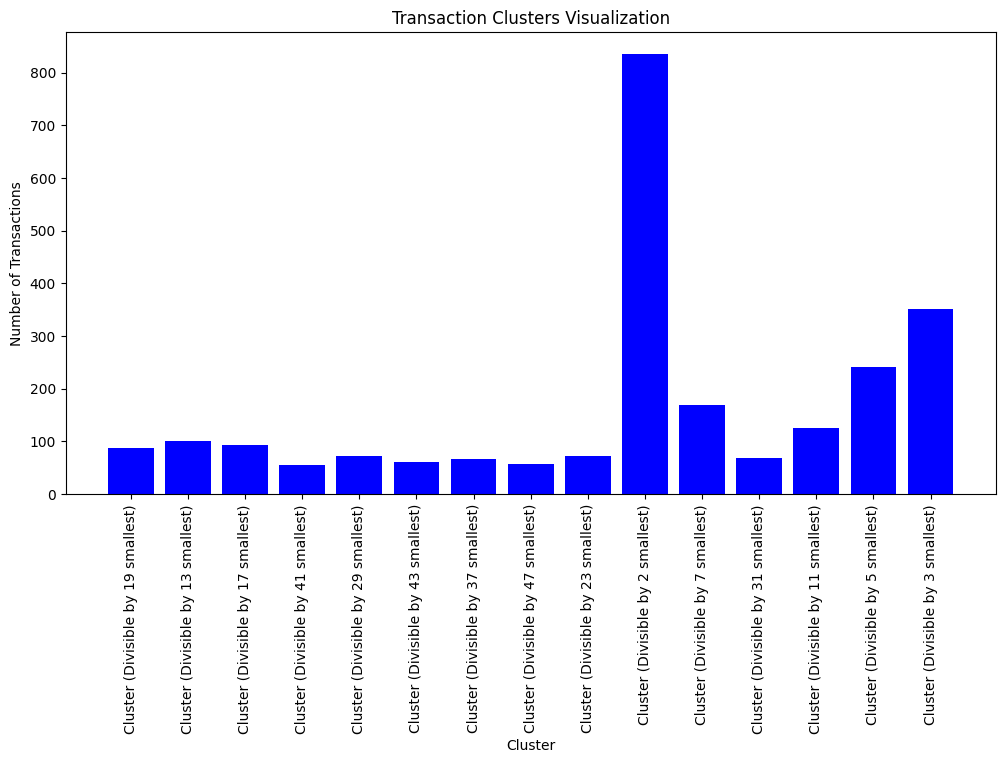

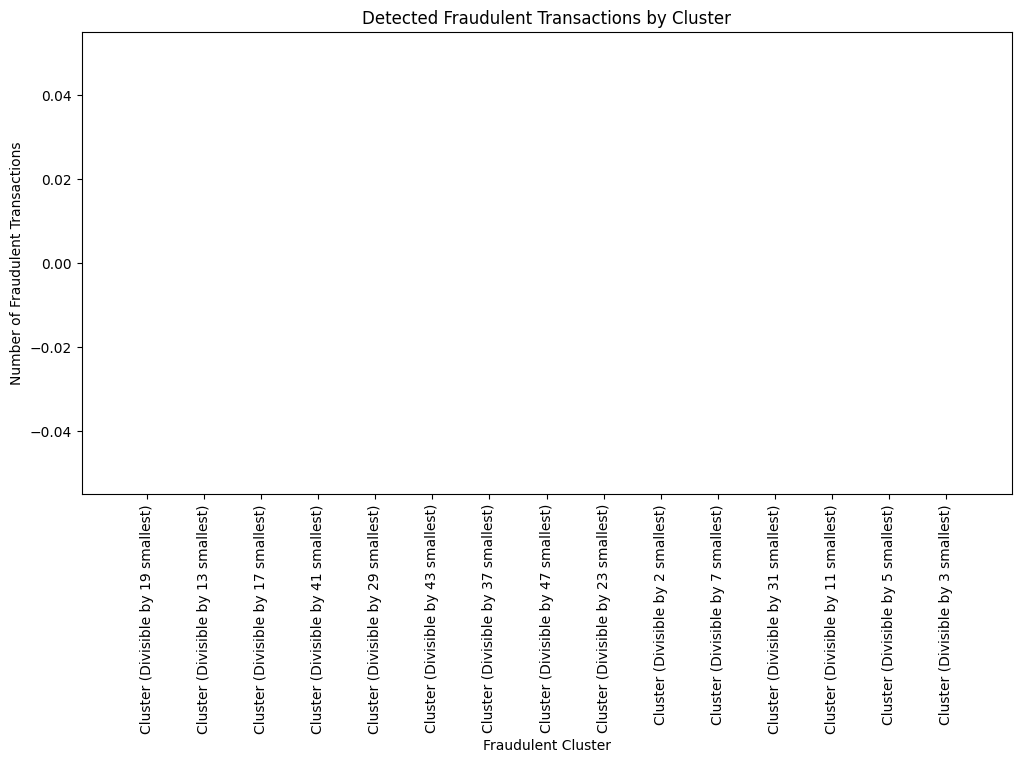

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

def calculate_exponent_p(n, p):
    """
    Calculate the exponent_p(n) based on the largest power of p that divides n.
    """
    alpha = 1
    while n % (p ** alpha) == 0:  # Check if p^alpha divides n
        alpha += 1
    return alpha - 1   # Return the largest valid alpha

def f(x, p):
    """
    Calculate f(x) = 1 / p^(exponent_p(n)).
    """
    exponent = calculate_exponent_p(x, p)
    return 1 / (p ** exponent)

def generate_primes(limit):
    """
    Generate a list of prime numbers up to a given limit.
    """
    sieve = [True] * (limit + 1)
    sieve[0] = sieve[1] = False
    for start in range(2, int(limit ** 0.5) + 1):
        if sieve[start]:
            for multiple in range(start * start, limit + 1, start):
                sieve[multiple] = False
    return [num for num, is_prime in enumerate(sieve) if is_prime]

def select_relevant_primes(data, prime_limit=50):
    """
    Select relevant primes based on whether they divide elements in the data.
    """
    primes = generate_primes(prime_limit)
    return [p for p in primes if any(x % p == 0 for x in data)]

def cluster_transactions(transaction_amounts, prime_limit=50, max_exponent=100):
    """
    Cluster transactions based on divisibility by dynamically selected primes.
    """
    selected_primes = select_relevant_primes(transaction_amounts, prime_limit)
    transformed_data = {
        f"Transformed by {p}": [transform_by_prime_safe(x, p, max_exponent) for x in transaction_amounts]
        for p in selected_primes
    }
    
    # Assign clusters based on the smallest transformation value
    clusters = []
    for x in transaction_amounts:
        valid_transformations = {p: transform_by_prime_safe(x, p, max_exponent) for p in selected_primes}
        min_prime = min(valid_transformations, key=lambda p: valid_transformations[p])
        clusters.append(f"Cluster (Divisible by {min_prime} smallest)")

    return transformed_data, clusters

def detect_fraudulent_transactions(transaction_amounts, clusters, threshold=300):
    """
    Detect fraudulent transactions based on clusters with a small number of transactions.
    Transactions in clusters with occurrences below the threshold are considered fraudulent.
    """
    cluster_counts = {cluster: clusters.count(cluster) for cluster in set(clusters)}
    fraudulent_clusters = [cluster for cluster, count in cluster_counts.items() if count <= threshold]
    fraudulent_transactions = [(amount, cluster) for amount, cluster in zip(transaction_amounts, clusters) if cluster in fraudulent_clusters]
    return fraudulent_transactions

# File input for credit card fraud detection dataset
input_file = "fraudTrain.csv"  # Replace with your file path
# Assuming the transaction amounts are in a column named 'Amount'
df = pd.read_csv(input_file)
transaction_amounts = df['amt'].astype(int).unique()

# Process transactions
transformed_data, clusters = cluster_transactions(transaction_amounts)

# Detect fraudulent transactions
fraudulent_transactions = detect_fraudulent_transactions(transaction_amounts, clusters, threshold=3)
print("Fraudulent Transactions:")
for amount, cluster in fraudulent_transactions:
    print(f"Transaction: {amount}, Cluster: {cluster}")

# Visualization of clusters
plt.figure(figsize=(12, 6))
cluster_counts = {cluster: clusters.count(cluster) for cluster in set(clusters)}
plt.bar(cluster_counts.keys(), cluster_counts.values(), color="blue")
plt.xticks(rotation=90)
plt.xlabel("Cluster")
plt.ylabel("Number of Transactions")
plt.title("Transaction Clusters Visualization")
plt.show()

# Visualization of fraudulent transactions
plt.figure(figsize=(12, 6))
fraud_counts = {cluster: sum(1 for x in fraudulent_transactions if x[1] == cluster) for cluster in set(clusters)}
plt.bar(fraud_counts.keys(), fraud_counts.values(), color="red")
plt.xticks(rotation=90)
plt.xlabel("Fraudulent Cluster")
plt.ylabel("Number of Fraudulent Transactions")
plt.title("Detected Fraudulent Transactions by Cluster")
plt.show()
